In [1]:
import pandas as pd
from cmapPy.pandasGEXpress.parse_gct import parse
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
import numpy as np
import urllib.request, json
import requests
import matplotlib.pyplot as plt

In [98]:
# Config
%matplotlib inline

In [2]:
data_parse = parse('../data/countMatrix.gct')
data = data_parse.data_df.T

In [3]:
def scale_data(data):
    return (data - data.mean()) / (data.max() - data.min())

In [4]:
samples = data.index.values
negative_sample_names = []
positive_sample_names = []
core_sample_names = []
for sample_name in samples:
    if "neg" in sample_name:
        negative_sample_names.append(sample_name)
    if "pos" in sample_name:
        positive_sample_names.append(sample_name)
    if "1" in sample_name:
        core_sample_names.append(sample_name)

In [5]:
scaled_data = scale_data(data)
negative_samples = data.loc[negative_sample_names]
positive_samples = data.loc[positive_sample_names]
core_samples = data.loc[core_sample_names]
scaled_negative = scaled_data.loc[negative_sample_names]
scaled_positive = scaled_data.loc[positive_sample_names]
scaled_core = scaled_data.loc[core_sample_names]
negative_samples.index = ['27', '28', '29', '30', '31', '33', '34', '37', '38', '40']
positive_samples.index = ['27', '28', '29', '30', '31', '33', '34', '37', '38', '40']
core_samples.index = ['27', '28', '29', '30', '31', '33', '34', '37', '38', '40']
scaled_negative.index = ['27', '28', '29', '30', '31', '33', '34', '37', '38', '40']
scaled_positive.index = ['27', '28', '29', '30', '31', '33', '34', '37', '38', '40']
scaled_core.index = ['27', '28', '29', '30', '31', '33', '34', '37', '38', '40']

In [6]:
expression_differential = negative_samples - positive_samples
mean_difference = expression_differential.mean()

In [8]:
mean_difference.sort_values(ascending=False)

rid
HBB       25867.667969
HBA2      16855.988281
HBA1      14685.716797
S100A9     7191.857910
S100A8     4922.477051
              ...     
APOE      -3879.011719
C1QA      -5043.845215
C1QB      -5382.215820
CCL4      -9430.874023
CCL3     -14621.046875
Length: 13475, dtype: float32

In [9]:
linear_model = LinearRegression()
top_coef = 0
top_gene = ""
gene_correlation = pd.DataFrame(columns=['Score'])
for gene_name in data.columns.values:
    if 0 in (negative_samples[gene_name] + positive_samples[gene_name]).values:
        continue
    all_samples_shaped = negative_samples[gene_name].append(positive_samples[gene_name]).values.reshape(-1, 1)
    linear_model.fit(all_samples_shaped, ([0] * negative_samples.shape[0]) + [1] * positive_samples.shape[0])
    coef = linear_model.coef_
    gene_correlation.loc[gene_name] = coef
    if coef > top_coef:
        top_coef = coef
        top_gene = gene_name
        print("Gene Name: {0} has correlation: {1}".format(gene_name, coef))

Gene Name: A4GALT has correlation: [0.01247817]
Gene Name: AANAT has correlation: [0.0154294]
Gene Name: ABCA4 has correlation: [0.05367116]
Gene Name: ADH1B has correlation: [0.06064701]
Gene Name: ANKDD1B has correlation: [0.22173338]
Gene Name: C12orf42 has correlation: [0.2722553]
Gene Name: FAM225A has correlation: [0.3383364]
Gene Name: GRINA has correlation: [0.4603218]
Gene Name: RENBP has correlation: [0.7222639]


In [149]:
# 5ALA +ve vs -ve SVM
svc = LinearSVC()
top_score = 0
top_gene = ""
svc_correlation = pd.DataFrame(columns=['Score'])
for gene_name in data.columns.values:
    if 0 in scaled_negative[gene_name].values or 0 in scaled_positive[gene_name].values:
        continue
    if np.sum(scaled_negative[gene_name] + scaled_positive[gene_name]) == 0:
        continue
    all_samples_shaped = scaled_negative[gene_name].append(scaled_positive[gene_name]).values.reshape(-1, 1)
    labels = ([0] * negative_samples.shape[0]) + [1] * positive_samples.shape[0]
    svc.fit(all_samples_shaped, labels)
    score = svc.score(all_samples_shaped, labels)
    svc_correlation.loc[gene_name] = score
    if score > top_score:
        top_score = score
        top_gene = gene_name
        print("Gene {0} has score {1}".format(gene_name, svc.score(all_samples_shaped, labels)))

Gene A1CF has score 0.6
Gene AADAT has score 0.65
Gene ABCA8 has score 0.75
Gene ACYP1 has score 0.8
Gene MDK has score 0.85
Gene TOR4A has score 0.9


In [148]:
# 5ALA +ve vs Core SVM
svc = LinearSVC()
top_score = 0
top_gene = ""
core_svc = pd.DataFrame(columns=['Score'])
for gene_name in data.columns.values:
    if 0 in scaled_core[gene_name].values or 0 in scaled_positive[gene_name].values:
        continue
    if np.sum(scaled_core[gene_name] + scaled_positive[gene_name]) == 0:
        continue
    all_samples_shaped = scaled_core[gene_name].append(scaled_positive[gene_name]).values.reshape(-1, 1)
    labels = ([0] * scaled_core.shape[0]) + [1] * positive_samples.shape[0]
    svc.fit(all_samples_shaped, labels)
    score = svc.score(all_samples_shaped, labels)
    core_svc.loc[gene_name] = score
    if score > top_score:
        top_score = score
        top_gene = gene_name
        print("Gene {0} has score {1}".format(gene_name, svc.score(all_samples_shaped, labels)))

Gene A1CF has score 0.55
Gene AAAS has score 0.85
Gene ABAT has score 0.9
Gene ARHGEF25 has score 0.95


In [54]:
# 5ALA +ve/-ve and Core 3 variable SVM
svc = LinearSVC()
top_score = 0
top_gene = ""
multi_svc = pd.DataFrame(columns=['Score'])
for gene_name in data.columns.values:
    if 0 in scaled_core[gene_name].values or 0 in scaled_positive[gene_name].values or 0 in scaled_negative[gene_name].values:
        continue
    if np.sum(scaled_core[gene_name] + scaled_positive[gene_name] + scaled_negative[gene_name]) == 0:
        continue
    all_samples_shaped = scaled_core[gene_name].append(scaled_positive[gene_name]).append(scaled_negative[gene_name]).values.reshape(-1, 1)
    labels = (["a"] * scaled_core.shape[0]) + (["b"] * positive_samples.shape[0]) + (["a"] * negative_samples.shape[0])
    svc.fit(all_samples_shaped, labels)
    score = svc.score(all_samples_shaped, labels)
    multi_svc.loc[gene_name] = score
    if score > top_score:
        top_score = score
        top_gene = gene_name
        print("Gene {0} has score {1}".format(gene_name, svc.score(all_samples_shaped, labels)))
multi_svc.sort_values(by='Score', ascending=False).head(10)

Gene A1CF has score 0.7
Gene ABCB4 has score 0.7333333333333333
Gene ADA2 has score 0.8
Gene AXL has score 0.8333333333333334
Gene CSRNP1 has score 0.8666666666666667
Gene TRIB1 has score 0.9


,Score
TRIB1,0.900000
SLC2A5,0.866667
CSRNP1,0.866667
SYNGR2,0.833333
PLEKHO2,0.833333
CD84,0.833333
KLF2,0.833333
KBTBD8,0.833333
IL10RA,0.833333
AXL,0.833333


In [40]:
def find_available_samples(sorted_gene_list, n):
    found_n = 0
    searched = 0
    for gene_name in sorted_gene_list.index.values:
        fetch_samples_url = "http://api.brain-map.org/api/v2/data/query.json?criteria=model::SectionDataSet,rma::criteria,treatments[name$eq\'ISH\'],genes[acronym$eq\'{0}\'],rma::include,genes,sub_images".format(gene_name)
        with urllib.request.urlopen(fetch_samples_url) as url:
            raw_json = json.loads(url.read().decode())
            searched += 1
            if raw_json['num_rows'] > 0:
                found_n += 1
                print("{0} ({1}) has {2} samples after searching {3}".format(gene_name, sorted_gene_list.loc[gene_name][0], raw_json['total_rows'], searched))
            if found_n >= n:
                break

In [42]:
# Find Difference Samples
#find_available_samples(mean_difference.sort_values(ascending=False), 5)

In [47]:
# Find Linear Regression Samples
gene_correlation_sorted = gene_correlation.sort_values(by='Score', ascending=False)
find_available_samples(gene_correlation_sorted, 5)

NameError: name 'gene_correlation' is not defined

In [48]:
# Find SVM Samples
svc_correlation_sorted = svc_correlation.sort_values(by='Score', ascending=False)
find_available_samples(svc_correlation_sorted, 5)

SRP9 (0.8) has 6 samples after searching 22
RPS6 (0.8) has 5 samples after searching 26
HTR7 (0.75) has 65 samples after searching 47
PAM (0.75) has 6 samples after searching 62
HDAC1 (0.75) has 8 samples after searching 64


In [163]:
# Find Multi-SVM Samples
multi_svc_sorted = multi_svc.sort_values(by='Score', ascending=False)
find_available_samples(multi_svc_sorted, 20)

SYNGR2 (0.8333333333333334) has 7 samples after searching 4
IL10RA (0.8333333333333334) has 8 samples after searching 9
GM2A (0.8333333333333334) has 4 samples after searching 14
STXBP2 (0.8333333333333334) has 5 samples after searching 16
NR4A2 (0.8333333333333334) has 102 samples after searching 21
IGF1 (0.8) has 6 samples after searching 32
STX11 (0.8) has 5 samples after searching 41
ZFHX3 (0.8) has 6 samples after searching 44
GPRIN3 (0.8) has 8 samples after searching 49
IL1B (0.8) has 6 samples after searching 57
ADH1B (0.8) has 8 samples after searching 88
PARVG (0.8) has 8 samples after searching 91
C3 (0.8) has 3 samples after searching 93
STARD8 (0.8) has 12 samples after searching 97
CTSH (0.8) has 48 samples after searching 104
KLF6 (0.7666666666666667) has 24 samples after searching 110
KLHL7 (0.7666666666666667) has 8 samples after searching 111
USP10 (0.7666666666666667) has 6 samples after searching 122
KCNK6 (0.7666666666666667) has 5 samples after searching 124
SORL1

In [150]:
core_vs_positive_svc = pd.DataFrame(columns=['Score'])
for gene_name in svc_correlation.index.values:
    core_vs_positive_svc.loc[gene_name] = core_svc.loc[gene_name] + svc_correlation.loc[gene_name]

In [158]:
# Find 5ALA+Core
core_vs_positive_sorted = core_vs_positive_svc.sort_values(by='Score', ascending=False)
find_available_samples(core_vs_positive_sorted, 15)

SRP9 (1.75) has 6 samples after searching 1
MPLKIP (1.7) has 8 samples after searching 9
PAM (1.65) has 6 samples after searching 24
IL1B (1.65) has 6 samples after searching 28
NR4A2 (1.65) has 102 samples after searching 40
KLHDC8A (1.65) has 8 samples after searching 41
PARK7 (1.6) has 15 samples after searching 68
ZNF674 (1.6) has 6 samples after searching 73
SYT12 (1.6) has 6 samples after searching 82
IL10RA (1.6) has 8 samples after searching 86
SYNGR2 (1.6) has 7 samples after searching 107
FYN (1.6) has 6 samples after searching 130
MECOM (1.6) has 562 samples after searching 144
SMAD1 (1.6) has 7 samples after searching 148
NDRG4 (1.55) has 24 samples after searching 156


In [50]:
core_svc_sorted = core_svc.sort_values(by='Score', ascending=False)
core_svc_sorted.head(5)

,Score
MPLKIP,0.700000
CCL4,0.666667
IP6K2,0.666667
PEX12,0.666667
CD320,0.666667


In [51]:
svc_correlation_sorted.head(5)

,Score
TOR4A,0.90
TRPM2,0.85
SF3B6,0.85
MDK,0.85
FCER1A,0.80


5ALA +ve/-ve Correlation: 0.75 
5ALA +ve/Core Correlation: 0.85


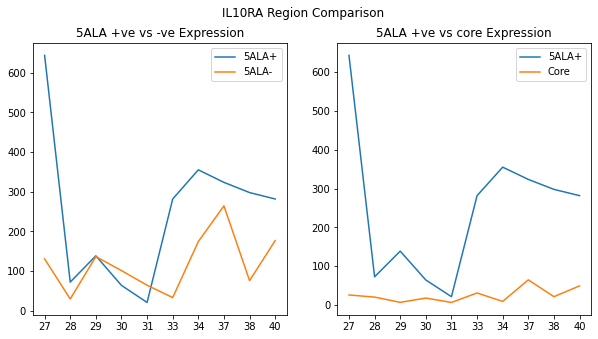

In [165]:
# %5ALA +ve vs -ve
target_gene = "IL10RA"
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("{0} Region Comparison".format(target_gene))
ax1.set_title('5ALA +ve vs -ve Expression')
ax1.plot(positive_samples[target_gene])
ax1.plot(negative_samples[target_gene])
ax2.set_title('5ALA +ve vs core Expression')
ax2.plot(positive_samples[target_gene])
ax2.plot(core_samples[target_gene])
ax1.legend(['5ALA+', '5ALA-'])
ax2.legend(['5ALA+', 'Core'])
print("5ALA +ve/-ve Correlation: {0} \n\
5ALA +ve/Core Correlation: {1}\
".format(svc_correlation.loc[target_gene]['Score'], core_svc.loc[target_gene]['Score']))
# plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

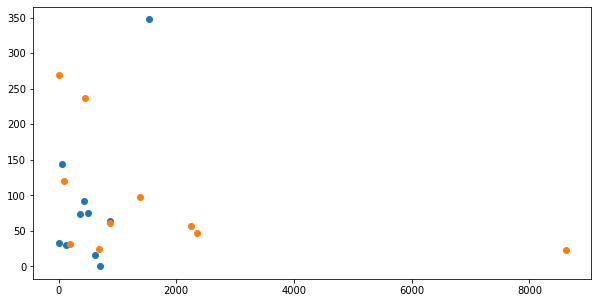

In [101]:
KLtarget_gene1 = "CCL2"
target_gene2 = "CD44"
plt.scatter(negative_samples[target_gene1], negative_samples[target_gene2])
plt.scatter(positive_samples[target_gene1], positive_samples[target_gene2])
plt.show()